In [1]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.color
import cv2
from mpl_toolkits.mplot3d import Axes3D
from src.cp_hw5 import *

# 1. Photometric stereo

## Initials

data/my_photo2/8.tiff
uint16
(500, 350, 3) 37123 121


Text(0.5, 1.0, 'Image 8')

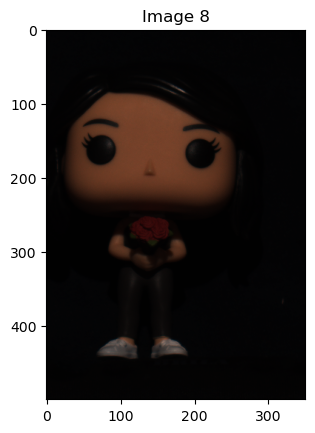

In [2]:
i = 8
path = 'data/my_photo2/' + str(i) + '.tiff'
print(path)
img_bgr = cv2.imread(path, -1)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

print(img_rgb.dtype)
#crop img_rgb
x_start = 1700
y_start = 2800
w = 700
h = 1000
img_rgb = img_rgb[x_start:x_start+h, y_start:y_start+w]

#sample img_rgb to img_rgb_sample
img_rgb = img_rgb[::2, ::2]

# img_rgb = np.array(img_rgb, dtype=np.float32)
print(img_rgb.shape, img_rgb.max(), img_rgb.min())
# Add a subplot to the existing figure
# plt.subplot(3, 3, i)  # Adjust grid size (3x3) as needed
plt.imshow(img_rgb/2**16)
plt.title(f"Image {i}")  # Optional title for each subplot


data/my_photo2/1.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(500, 350, 3) 6402 0
data/my_photo2/2.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(500, 350, 3) 6173 0
data/my_photo2/3.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(500, 350, 3) 7675 0
data/my_photo2/4.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(500, 350, 3) 7688 81
data/my_photo2/5.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(500, 350, 3) 7280 66
data/my_photo2/6.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(500, 350, 3) 8368 0
data/my_photo2/7.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(500, 350, 3) 7416 0


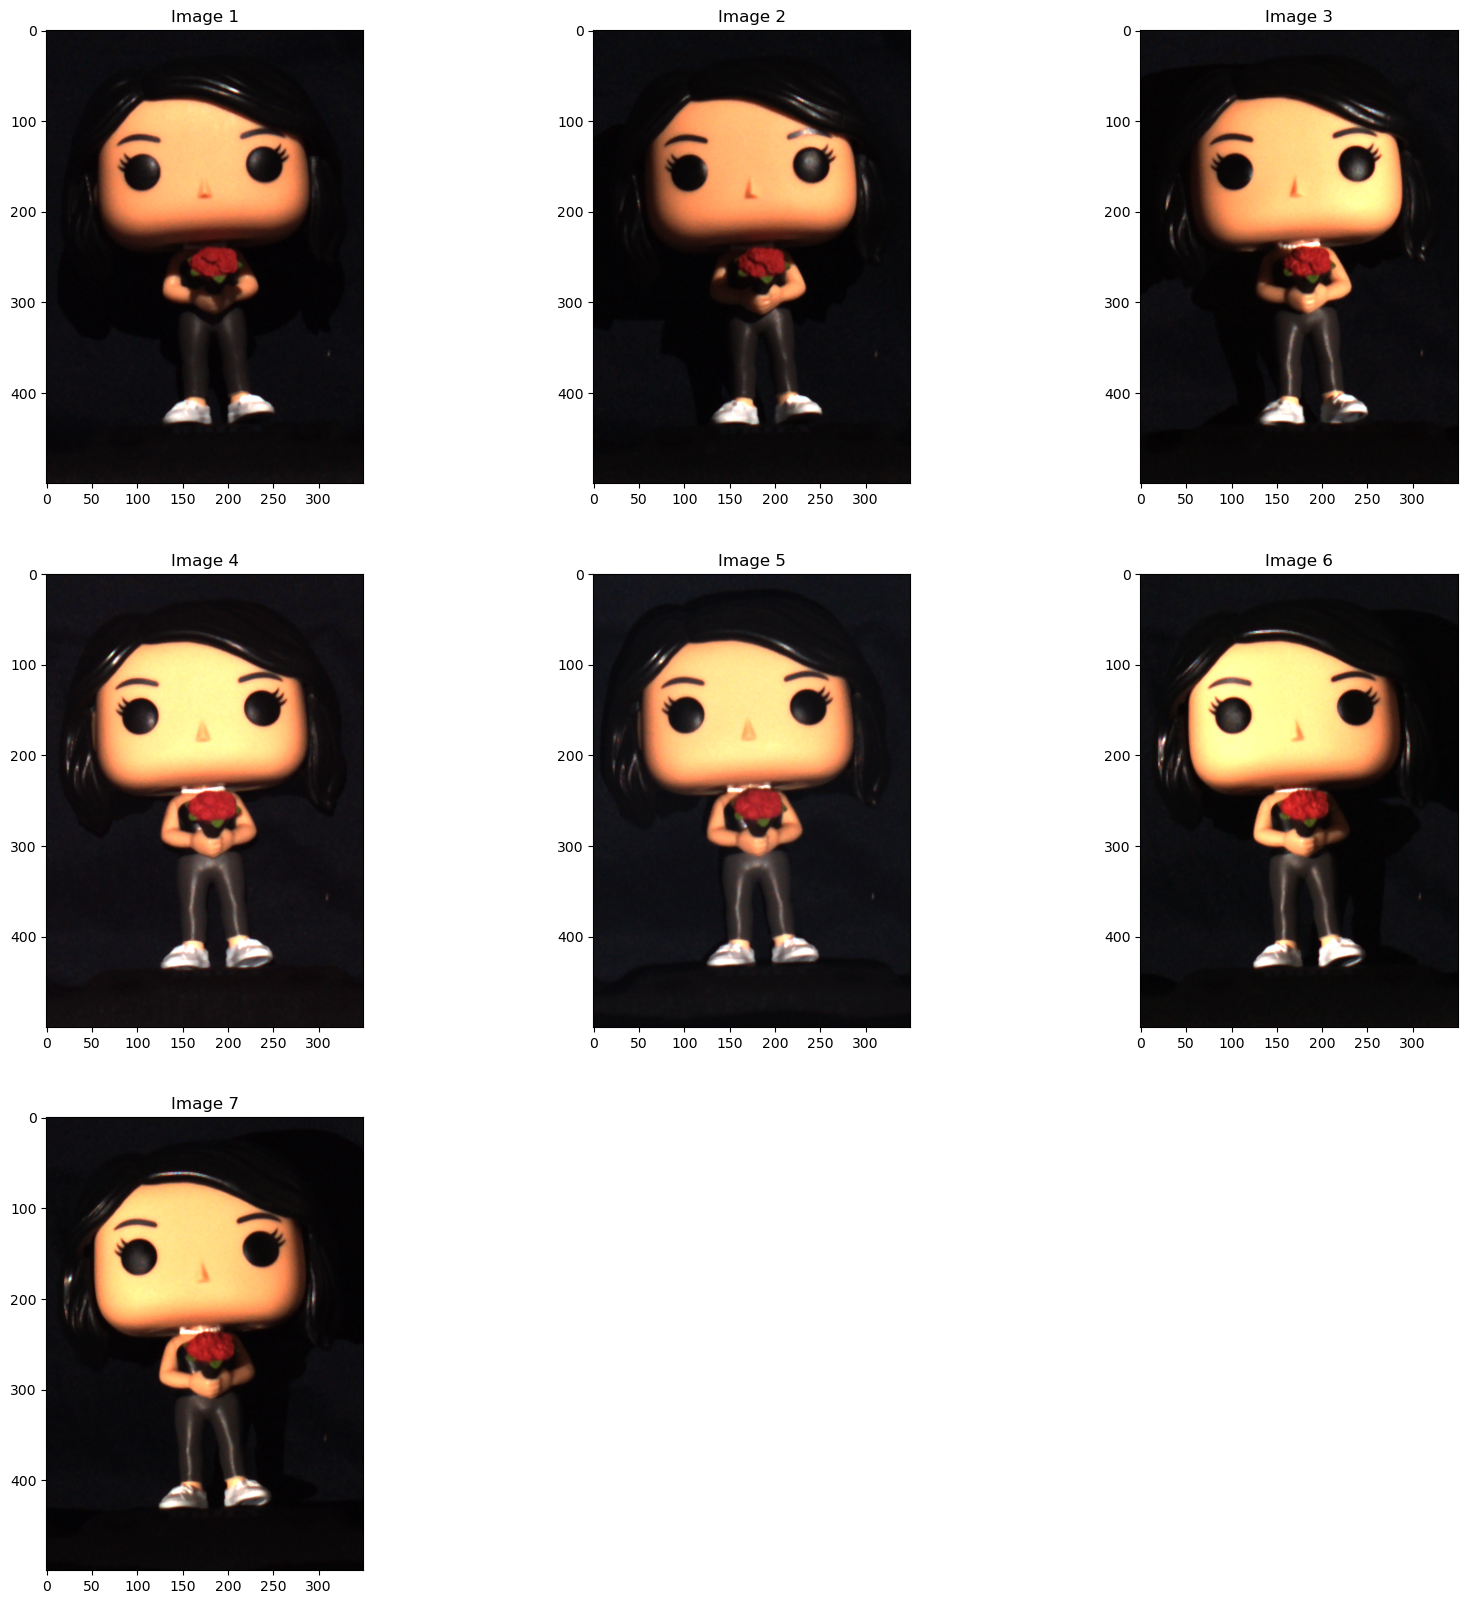

In [15]:
img_luminance_list = []

# Create a single figure outside the loop
plt.figure(figsize=(20, 20))  # Adjust the size as needed

for i in range(1, 8):

    path = 'data/my_photo2/' + str(i) + '.tiff'
    # path = 'data/my_photo2/' + str(i) + '.nef'

    print(path)
    img_bgr = cv2.imread(path, -1)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    #crop img_rgb
    x_start = 1700
    y_start = 2800
    w = 700
    h = 1000
    img_rgb = img_rgb[x_start:x_start+h, y_start:y_start+w]

    #sample img_rgb to img_rgb_sample
    img_rgb = img_rgb[::2, ::2]
        
    #Box filter img_rgb for noise reduction
    # img_rgb = cv2.blur(img_rgb, (3, 3))
    
    # # noise reduction by filtering
    img_rgb = cv2.medianBlur(img_rgb, 3)
    
    # img_rgb = np.array(img_rgb, dtype=np.float32)
    print(img_rgb.shape, img_rgb.max(), img_rgb.min())
    # Add a subplot to the existing figure
    plt.subplot(3, 3, i)  # Adjust grid size (3x3) as needed
    plt.imshow(img_rgb/2**12)
    plt.title(f"Image {i}")  # Optional title for each subplot

    img_xyz = skimage.color.rgb2xyz(img_rgb)
    img_y = img_xyz[:, :, 1].reshape((img_xyz.shape[0] * img_xyz.shape[1]))
    img_luminance_list.append(img_y)

# Display the figure with all subplots
plt.show()

I = np.array(img_luminance_list)
s = img_xyz.shape


## Uncalibrated photometric stereo

In [16]:
def compute_pseudonor_uncal(I):
    """
    Compute pseudonormals without the help of light source directions.

    Input
    I : numpy.ndarray
        The 7 x P matrix of loaded images

    Output
    B_e : numpy.ndarray
        The 3 x P matrix of pseudonormals
    L_e : numpy.ndarray
        The estimated light source directions
    """

    # Perform Singular Value Decomposition (SVD) on the input matrix I
    U, S, Vt = np.linalg.svd(I, full_matrices=False)

    # Zero out the singular values beyond the first three
    S[3:] = 0

    # Reconstruct the matrix I with reduced dimensions
    I = U @ np.diag(S) @ Vt

    # Calculate U' and Vt' by scaling U and Vt with the square root of the singular values
    # This step prepares for the extraction of pseudonormals and light source directions
    U_prime = U @ np.diag(np.sqrt(S))
    Vt_prime = np.diag(np.sqrt(S)) @ Vt

    # Extract the top 3 rows of U' and Vt' as the estimated light source directions (L_e)
    # and pseudonormals (B_e), respectively
    L_e = U_prime[:3]
    B_e = Vt_prime[:3]

    return B_e, L_e


In [17]:
B_e, L_e = compute_pseudonor_uncal(I)

In [18]:
print(B_e.shape, L_e.shape)

(3, 175000) (3, 7)


In [19]:
def compute_albedos_normals(B):
    """
    From the estimated pseudonormals, seperate the albedos and normals.

    Input
    B : numpy.ndarray
        The 3 x P matrix of estimated pseudonormals

    Output
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals
    """

    # Calculate the albedo by finding the norm of each pseudonormal
    albedos = np.linalg.norm(B, axis=0)

    # Calculate the normals by normalizing the pseudonormals
    # A small value is added to the denominator to avoid division by zero
    normals = B / (albedos + 1e-10)

    return albedos, normals

def convert_albedos_normals_to_img(albedos, normals, s, title=''):
    """
    From the estimated pseudonormals, display the albedo and normal maps.
    Use the `coolwarm` colormap for the albedo image and the `rainbow` colormap for the normals.

    Parameters
    ----------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    -------
    img_albedo : numpy.ndarray
        Albedo image of shape s

    img_normal : numpy.ndarray
        Normals reshaped as an s x 3 image
    """

    # Normalize albedos for display
    albedos = (albedos - np.min(albedos)) / (np.max(albedos) - np.min(albedos))

    # Normalize normals for display
    normals = (normals - np.min(normals)) / (np.max(normals) - np.min(normals))

    # Reshape the albedos to the image shape
    img_albedo = albedos.reshape(s[0], s[1])

    # Reshape the normals and transpose it to align with the image shape
    img_normal = normals.T.reshape(s[0], s[1], 3)

    return img_albedo, img_normal


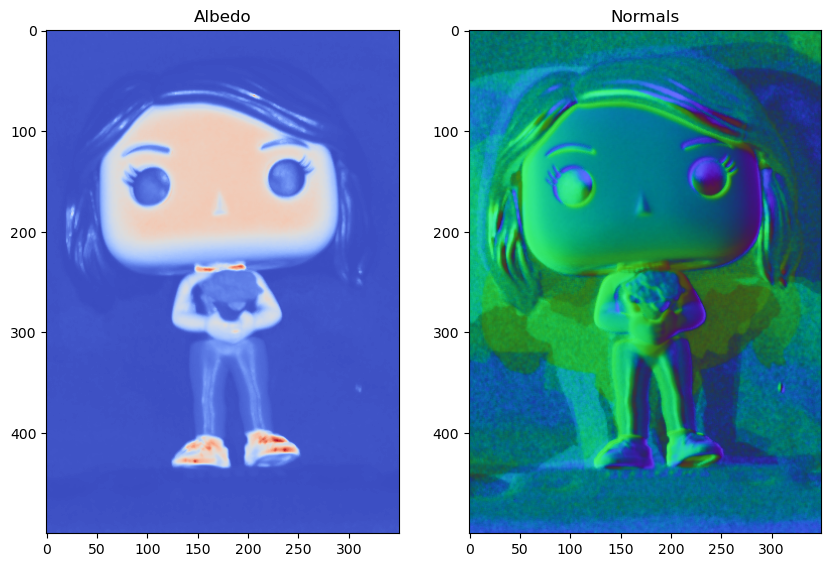

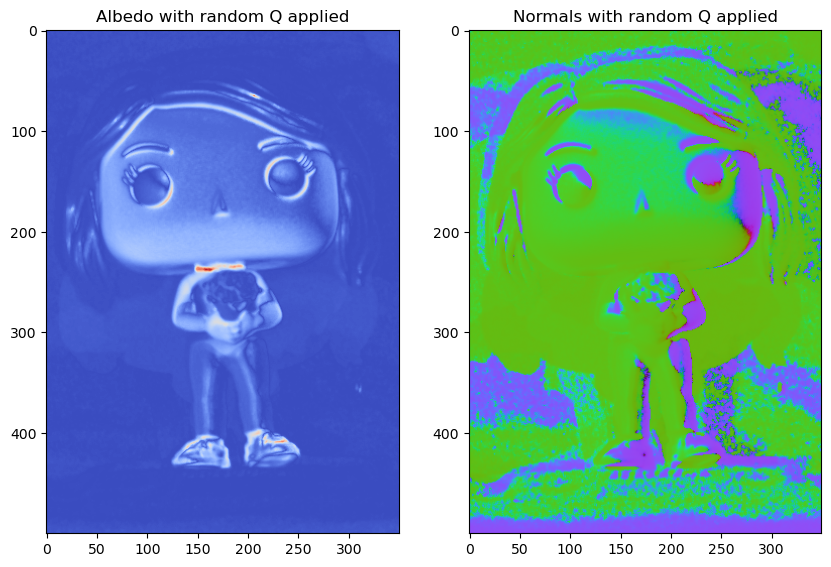

In [20]:

albedos, normals = compute_albedos_normals(B_e)
img_albedo, img_normal = convert_albedos_normals_to_img(albedos, normals,s)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(img_albedo, cmap='coolwarm')
plt.title('Albedo')
# plt.show()

plt.subplot(122)
plt.imshow(img_normal, cmap='rainbow')
plt.title('Normals')
plt.show()

# generate random invertible matrix Q
matix_rand = np.random.rand(3,3)
eps = 0.00000001
Q = np.eye(3) * eps + matix_rand@matix_rand.T
Q_inv = np.linalg.inv(Q)

L_Q = Q @ L_e
B_Q = Q_inv.T @ B_e

albedos_Q, normals_Q = compute_albedos_normals(B_Q)
img_albedo_Q, img_normal_Q = convert_albedos_normals_to_img(albedos_Q, normals_Q,s, 'From randomly generated BQ')

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(img_albedo_Q, cmap='coolwarm')
plt.title('Albedo with random Q applied')
# plt.show()

plt.subplot(122)
plt.imshow(img_normal_Q, cmap='rainbow')
plt.title('Normals with random Q applied')
plt.show()

## Enforcing integrability

In [21]:
from scipy.ndimage import gaussian_filter

def enforce_integrability(B_e, s, sig=3):
    """
    Finds a transform Q that makes the normals integrable and transforms them by it.

    Input
    ----------
    B_e : numpy.ndarray
        The 3 x P matrix of (possibly) non-integrable normals
    s : tuple
        Image shape
    sig : float, optional
        Sigma value for Gaussian filter

    Output
    -------
    B_til : numpy.ndarray
        The 3 x P matrix of transformed, integrable normals
    """

    # Reshape the components of B_e to match the image shape
    b_e1 = B_e[0, :].reshape(s)
    b_e2 = B_e[1, :].reshape(s)
    b_e3 = B_e[2, :].reshape(s)

    # Apply Gaussian filter and compute gradients for each component
    b_e1_y, b_e1_x = np.gradient(gaussian_filter(b_e1, sig), edge_order=2)
    b_e2_y, b_e2_x = np.gradient(gaussian_filter(b_e2, sig), edge_order=2)
    b_e3_y, b_e3_x = np.gradient(gaussian_filter(b_e3, sig), edge_order=2)

    # Compute elements of matrix A based on gradients and components of B_e
    A1 = b_e1*b_e2_x - b_e2*b_e1_x
    A2 = b_e1*b_e3_x - b_e3*b_e1_x
    A3 = b_e2*b_e3_x - b_e3*b_e2_x
    A4 = -b_e1*b_e2_y + b_e2*b_e1_y
    A5 = -b_e1*b_e3_y + b_e3*b_e1_y
    A6 = -b_e2*b_e3_y + b_e3*b_e2_y

    # Combine computed elements into matrix A
    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))

    # Calculate AtA (A transpose multiplied by A)
    AtA = A.T.dot(A)

    # Perform eigenvalue decomposition of AtA
    W, V = np.linalg.eig(AtA)

    # Select eigenvector corresponding to the smallest absolute eigenvalue
    h = V[:, np.argmin(np.abs(W))]

    # Construct matrix delta using elements of h
    delta = np.asarray([[-h[2],  h[5], 1],
                        [ h[1], -h[4], 0],
                        [-h[0],  h[3], 0]])

    # Apply the inverse of delta to B_e to get integrable normals
    B_til = np.linalg.inv(delta).dot(B_e)

    return B_til


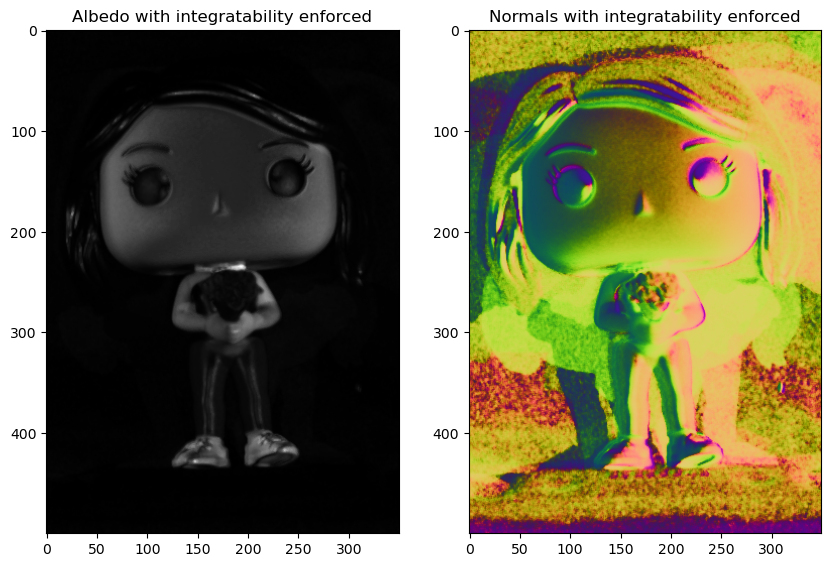

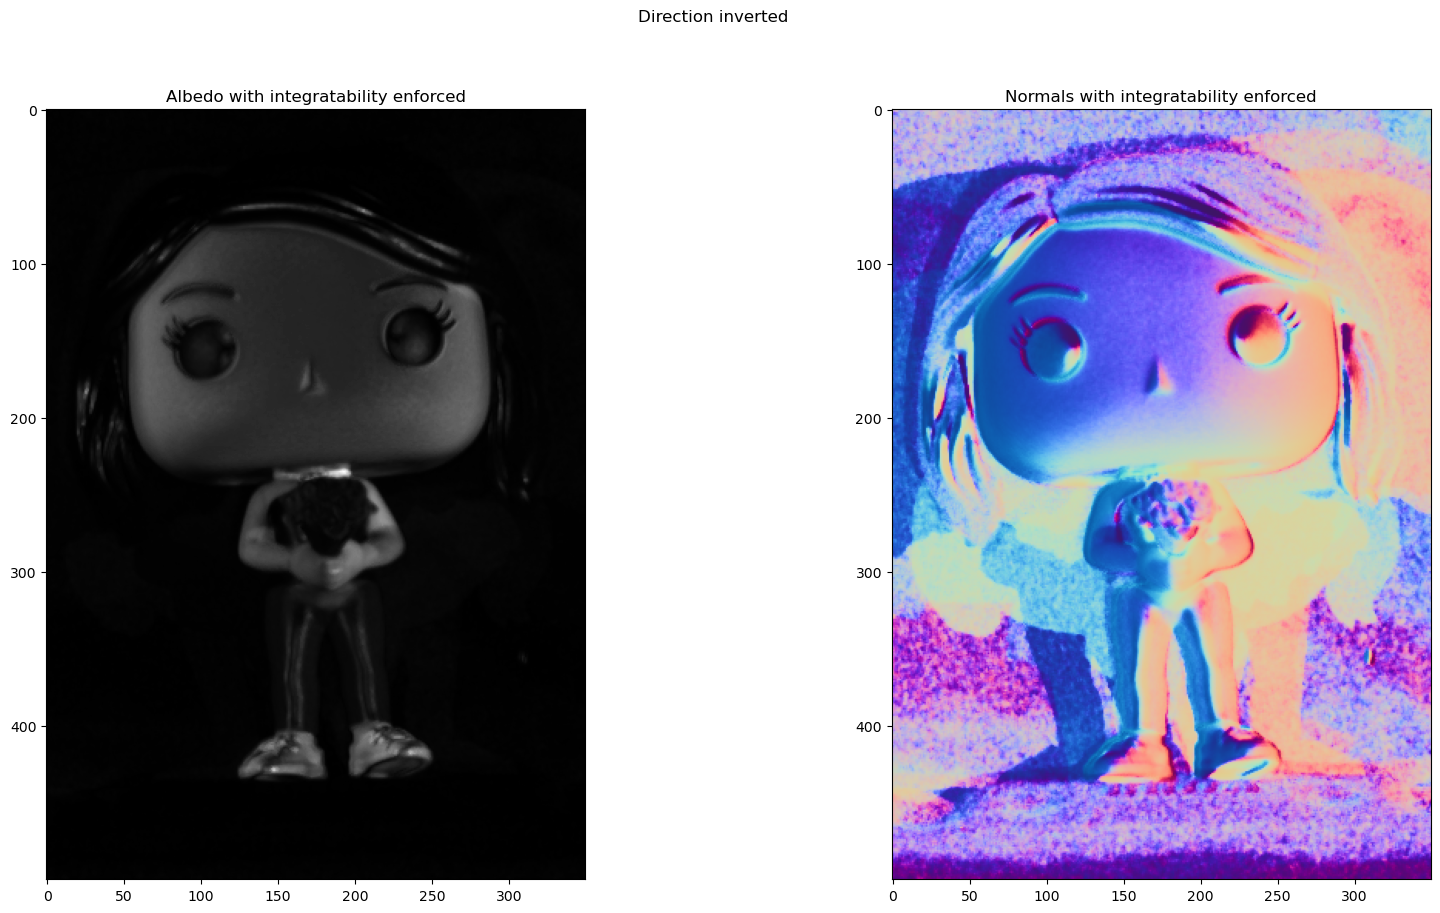

In [22]:
# enforcing integratability on Be
B_e_enf_int = enforce_integrability(B_e, s[:2])
albedos_enf_int, normals_enf_int = compute_albedos_normals(B_e_enf_int)
img_albedo_enf_int, img_normal_enf_int = convert_albedos_normals_to_img(albedos_enf_int, normals_enf_int, s, 'PseudoNormals integratability enforced')

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(img_albedo_enf_int, cmap='gray')
plt.title('Albedo with integratability enforced')
# plt.show()

plt.subplot(122)
plt.imshow(img_normal_enf_int, cmap='rainbow')
plt.title('Normals with integratability enforced')
plt.show()

# Applying GBR inversion transform
G_F = np.array([[1,0,0],[0,1,0],[0,0,-1]])
B_e_enf_int = G_F @ B_e_enf_int 
albedos_enf_int, normals_enf_int = compute_albedos_normals(B_e_enf_int)
img_albedo_enf_int, img_normal_enf_int = convert_albedos_normals_to_img(albedos_enf_int, normals_enf_int, s, 'PseudoNormals integratability enforced after inversion of direction')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img_albedo_enf_int, cmap='gray')
plt.title('Albedo with integratability enforced')
# plt.show()

plt.subplot(122)
plt.imshow(img_normal_enf_int, cmap='rainbow')
plt.title('Normals with integratability enforced')

plt.suptitle('Direction inverted')

plt.show()


## Normal integration

In [23]:
def display_depth_3D(surface, title=''):
    """
    Plot the depth map as a surface.

    Input
    ----------
    surface : numpy.ndarray
        The depth map to be plotted.

    title : str, optional
        Title of the plot.

    Output
    -------
    None
    """

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Creating a meshgrid for the surface plot
    X, Y = np.meshgrid(np.arange(surface.shape[0]), np.arange(surface.shape[1]))

    # Plotting the surface using the coolwarm colormap
    ax.plot_surface(X.T, Y.T, surface, cmap='coolwarm')

    if title:
        plt.title(title)

    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D

def display_depth_3d_w_light(Z, flip_z=False):
    """
    Plot the depth map as a surface with lighting effects.

    Input
    ----------
    Z : numpy.ndarray
        The HxW array of surface depths.

    flip_z : bool, optional
        If True, flips the Z-axis.

    Output
    -------
    None
    """

    H, W = Z.shape
    x, y = np.meshgrid(np.arange(W), np.arange(H))

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Add lighting effect
    ls = LightSource()
    if flip_z:
        Z = -Z
    color_shade = ls.shade(Z, plt.cm.gray)

    # Display the surface with lighting
    ax.plot_surface(x, y, Z, facecolors=color_shade, rstride=4, cstride=4)

    plt.show()

import numpy as np

def integrate_normals(normals, s, mode):
    """
    Integrate the estimated normals to get an estimate of the depth map of the surface.

    Input
    ----------
    normals : numpy.ndarray
        The 3 x P matrix of normals.

    s : tuple
        Image shape.

    mode : int
        Integration mode (0 for Poisson, 1 for Frankot-Chellappa).

    Output
    ----------
    surface : numpy.ndarray
        The image of estimated depths at each point.
    """

    # Reshape and normalize normals for integration
    f_x = np.reshape(normals[0, :] / (-normals[2, :] + 1e-10), s[:2])
    f_y = np.reshape(normals[1, :] / (-normals[2, :] + 1e-10), s[:2])

    title = ''
    if mode == 0:
        surface = integrate_poisson(f_x, f_y)
        title = 'Poisson Integration'
    elif mode == 1:
        surface = integrate_frankot(f_x, f_y)
        title = 'Frankot-Chellappa Integration'
    else:
        print('Mode should be 0 or 1')
        return None

    # Normalize the surface for display
    surface = (surface - np.min(surface)) / (np.max(surface) - np.min(surface))

    # Display the depth map
    display_depth_3D(surface, title)

    return surface


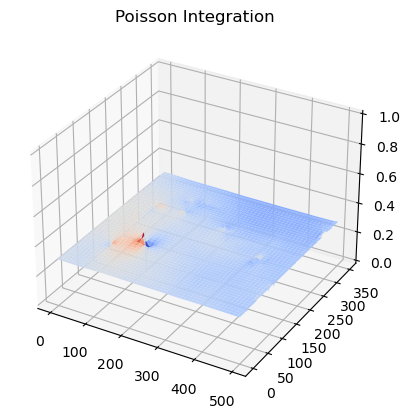

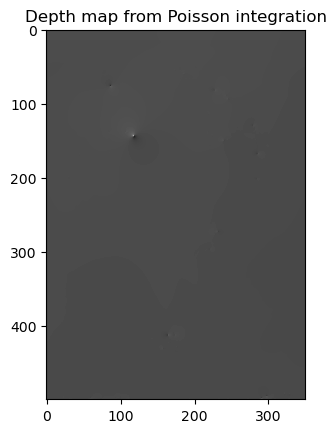

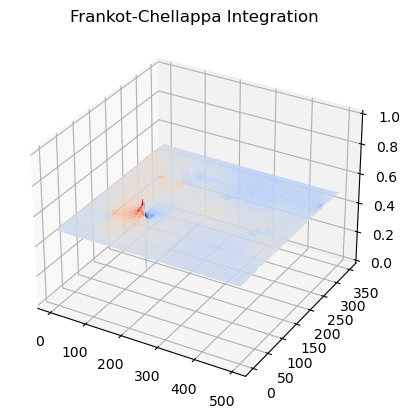

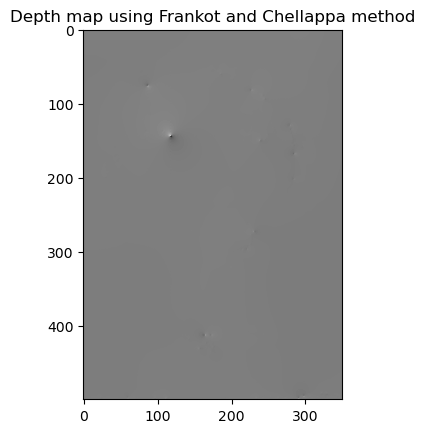

In [24]:
# Normal Integration
surface_poisson = integrate_normals(normals_enf_int, s, 0)
# np.save('surface_poisson_mine1.npy', surface_poisson)

plt.imshow(surface_poisson, cmap='gray')
plt.title('Depth map from Poisson integration')
plt.show()

# display_depth_3d_w_light(surface_poisson)
# plt.show()

surface_frankot = integrate_normals(normals_enf_int, s, 1)
# np.save('surface_frankot_mine1.npy', surface_frankot)

plt.imshow(surface_frankot, cmap='gray')
plt.title('Depth map using Frankot and Chellappa method')
plt.show()
# display_depth_3d_w_light(surface_frankot)
# plt.show()

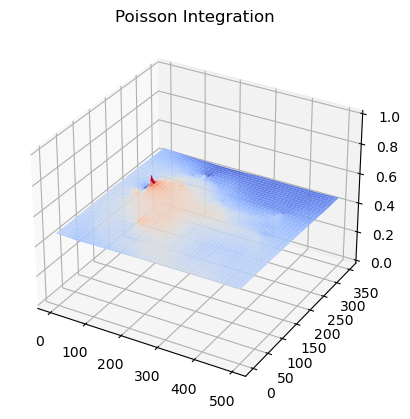

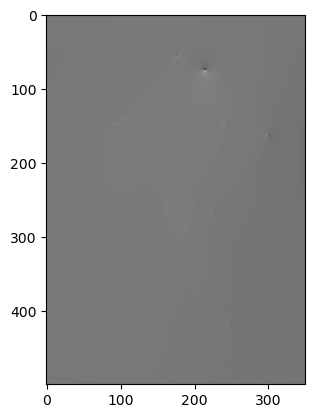

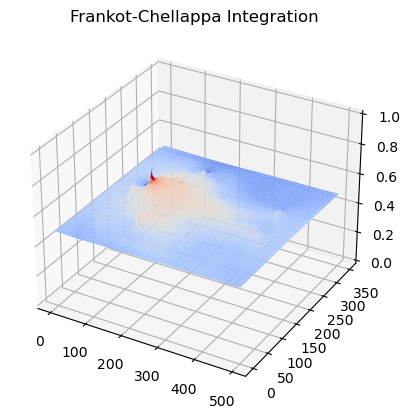

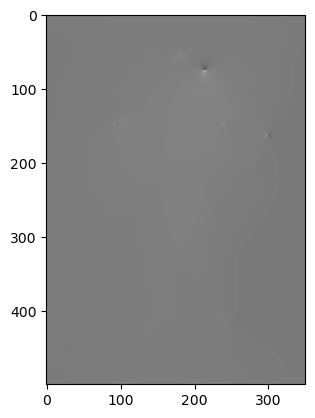

In [25]:
# Try with different G matrices

u = 2
v = 2
l = 1
G = np.array([[1,0,0],[0,1,0],[u,v,l]])
B_e_new = np.linalg.inv(G.T) @ B_e

# Estimate normals and enforce integratability

# enforcing integratability
B_e_enf_int = enforce_integrability(B_e_new, s[:2])
albedos_enf_int, normals_enf_int = compute_albedos_normals(B_e_enf_int)
img_albedo_enf_int, img_normal_enf_int = convert_albedos_normals_to_img(albedos_enf_int, normals_enf_int, s, 'PseudoNormals integratability enforced')

# Applying GBR inversion transform
G_F = np.array([[1,0,0],[0,1,0],[0,0,-1]])
B_e_enf_int = G_F @ B_e_enf_int 
albedos_enf_int, normals_enf_int = compute_albedos_normals(B_e_enf_int)
img_albedo_enf_int, img_normal_enf_int = convert_albedos_normals_to_img(albedos_enf_int, normals_enf_int, s, 'PseudoNormals integratability enforced after inversion of direction')

# Normal Integration
surface_poisson = integrate_normals(normals_enf_int, s, 0)
plt.imshow(surface_poisson, cmap='gray')
plt.show()
# display_depth_3d_w_light(surface_poisson)
# plt.show()

surface_frankot = integrate_normals(normals_enf_int, s, 1)
np.save('surface_frankot_mine2.npy', surface_frankot)
plt.imshow(surface_frankot, cmap='gray')
plt.show()
# display_depth_3d_w_light(surface_frankot)
# plt.show()

## Entropy minimization

In [26]:
from scipy.stats import entropy

def compute_albedo_entropy(albedos):
    hist, _ = np.histogram(albedos, bins=256, range=(0, 1), density=True)
    return entropy(hist)

def find_optimal_gbr(B_e, num_transformations=100):
    best_entropy = float('inf')
    best_gbr = None

    for _ in range(num_transformations):
        # Randomly select u, v, and l (ensure l != 0)
        u, v = np.random.rand(2)
        l = np.random.rand() * 10 + 0.1  # Ensuring l is not too close to 0

        gbr = np.array([[1, 0, 0], [0, 1, 0], [u, v, l]])

        # Apply GBR transformation
        transformed_normals = np.linalg.inv(gbr).T @ B_e

        # Compute albedos from transformed normals
        albedos = np.linalg.norm(transformed_normals, axis=0)

        # Compute entropy
        current_entropy = compute_albedo_entropy(albedos)

        # Check if this is the best (lowest entropy) transformation
        if current_entropy < best_entropy:
            best_entropy = current_entropy
            best_gbr = gbr

    return best_gbr

optimal_gbr = find_optimal_gbr(B_e)
print("Optimal GBR Transformation:\n", optimal_gbr)


Optimal GBR Transformation:
 [[1.         0.         0.        ]
 [0.         1.         0.        ]
 [0.9339085  0.07479087 3.04737337]]


Optimal GBR Transformation:
 [[ 1.          0.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.98163019  0.93137916 10.06555115]]


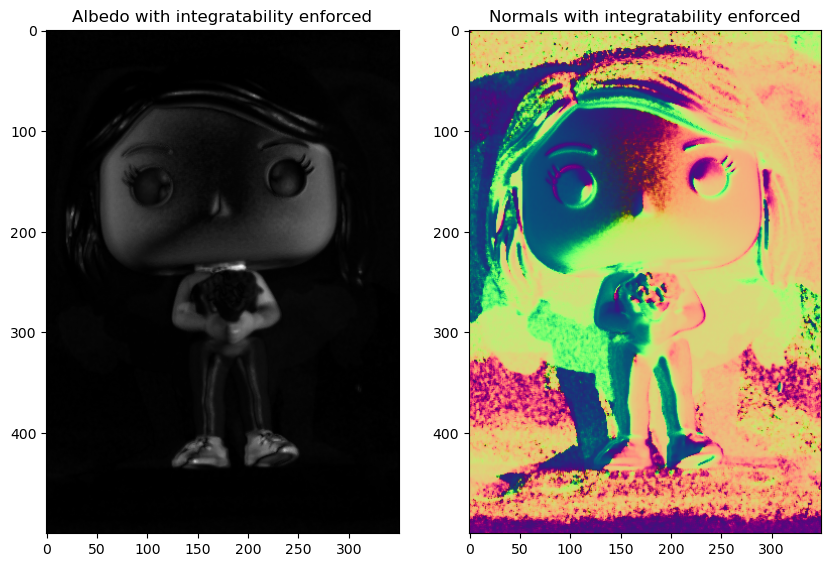

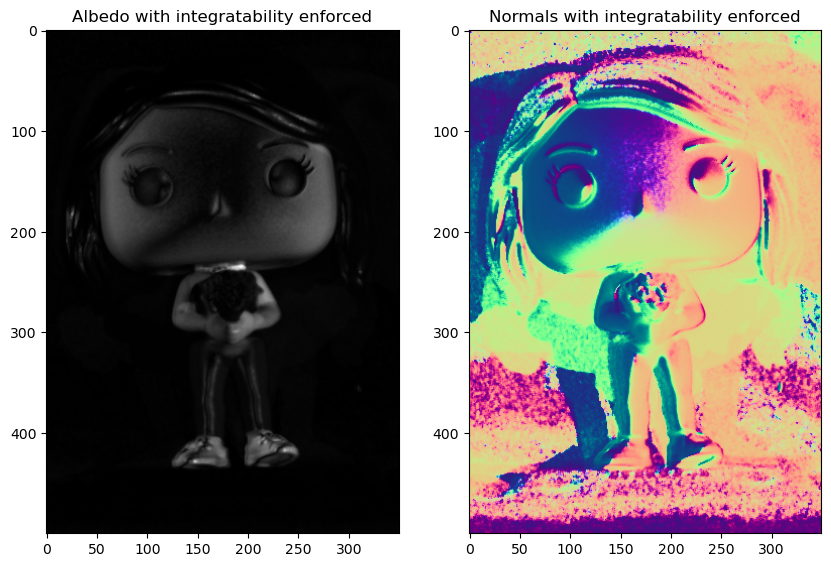

In [27]:
# Enforce integrability on B_e
B_e_integrated = enforce_integrability(B_e, s[:2])

# Find the optimal GBR transformation for the integrability-enforced normals
optimal_gbr = find_optimal_gbr(B_e_integrated, num_transformations=3000)
print("Optimal GBR Transformation:\n", optimal_gbr)

# Apply the optimal GBR transformation
B_e_transformed = np.linalg.inv(optimal_gbr).T @ B_e_integrated 

albedos_transformed, normals_transformed = compute_albedos_normals(B_e_transformed)

img_albedo_entropy, img_normal_entropy = convert_albedos_normals_to_img(albedos_transformed, normals_transformed, s, 'PseudoNormals integratability enforced')

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(img_albedo_entropy, cmap='gray')
plt.title('Albedo with integratability enforced')
# plt.show()

plt.subplot(122)
plt.imshow(img_normal_entropy, cmap='rainbow')
plt.title('Normals with integratability enforced')
plt.show()


# Applying GBR inversion transform
G_F = np.array([[1,0,0],[0,1,0],[0,0,-1]])
B_e_transformed = G_F @ B_e_transformed
# Continue with your process (compute albedos, normals, etc.)
albedos_transformed, normals_transformed = compute_albedos_normals(B_e_transformed)
# ... additional processing ...

img_albedo_entropy, img_normal_entropy = convert_albedos_normals_to_img(albedos_transformed, normals_transformed, s, 'PseudoNormals integratability enforced')

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(img_albedo_entropy, cmap='gray')
plt.title('Albedo with integratability enforced')
# plt.show()

plt.subplot(122)
plt.imshow(img_normal_entropy, cmap='rainbow')
plt.title('Normals with integratability enforced')
plt.show()


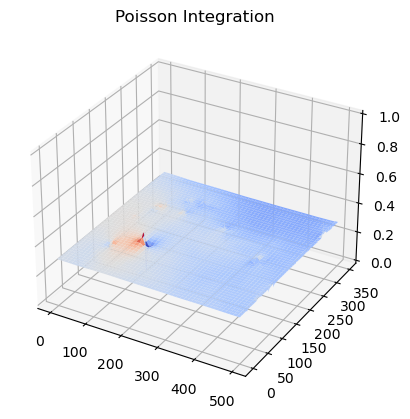

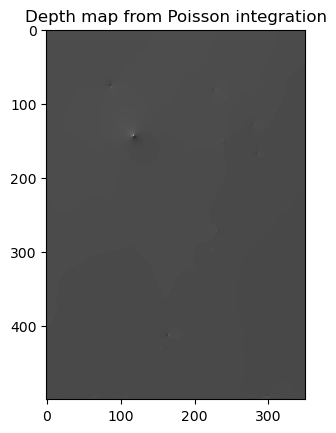

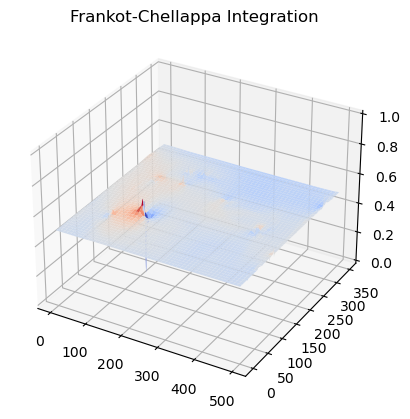

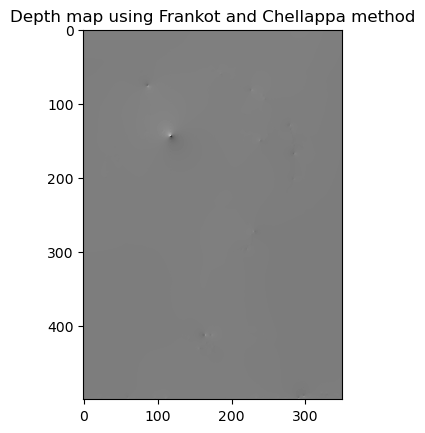

In [28]:
# Normal Integration
surface_poisson = integrate_normals(normals_transformed, s, 0)
# np.save('surface_poisson.npy', surface_poisson)

plt.imshow(surface_poisson, cmap='gray')
plt.title('Depth map from Poisson integration')
plt.show()

# display_depth_3d_w_light(surface_poisson)
# plt.show()

surface_frankot = integrate_normals(normals_transformed, s, 1)
np.save('surface_frankot_entropy.npy', surface_frankot)

plt.imshow(surface_frankot, cmap='gray')
plt.title('Depth map using Frankot and Chellappa method')
plt.show()
# display_depth_3d_w_light(surface_frankot)
# plt.show()

## Rendering of both objects under a new lighting direction

In [54]:
print(L_e, L_e.shape)

[[-0.43706575 -0.10413304  0.30004801  0.          0.          0.
   0.        ]
 [-0.41112877 -0.29700022  0.14190891  0.          0.          0.
   0.        ]
 [-0.5212003  -0.3490069  -0.17232022  0.          0.          0.
   0.        ]] (3, 7)


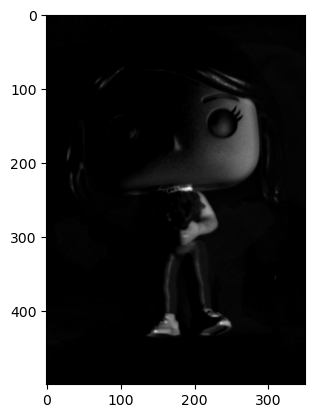

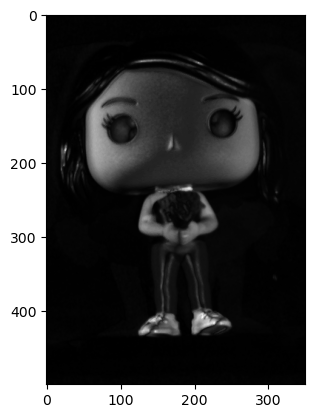

In [55]:
# Custom light, far right
L_custom = L_e[:, 2]
ndotl = np.dot(img_normal_enf_int, L_custom)
rad_field = img_albedo_enf_int * ndotl
rad_field[rad_field < 0] = 0
plt.imshow(rad_field, cmap='gray')
plt.show()


L_custom = np.array([-1,-2,10]) 
L_custom = L_custom / np.linalg.norm(L_custom)
ndotl = np.dot(img_normal_enf_int, L_custom)
rad_field = img_albedo_enf_int * ndotl
rad_field[rad_field < 0] = 0
plt.imshow(rad_field, cmap='gray')
plt.show()
